In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import scipy
import csv

from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score

In [2]:
# dataset params
all_data_file = "./data/processed_sheets_pull.csv"
train_data_file = "./data/train.csv"
val_data_file = "./data/val.csv"
label_range = ["pee & hand washing", "poo", "object cleaning"]
feature_used = [
    "elapsed_time",
    "total_sheets_used",
    "number_pulled",
    "max_min_pull_diff",
    "average_time_between_pulls",
    "average_sheets_between_pulls",
    "max_time_duration",
    "max_sheets_pull"
]
num_classes = 3

In [3]:
def compute_contigency_matrix(predicted, labels):
    # return: dict[gt_label][cluster_idx]
    assert predicted.shape == labels.shape
    assert len(predicted.shape) == 1
    ret_dict = {}
    assert np.min(predicted) == 0, "cluster idx starts from zero"
    max_cluster_idx = np.max(predicted)
    for name in label_range:
        ret_dict[name] = np.zeros((max_cluster_idx + 1,))
    for i in range(predicted.shape[0]):
        ret_dict[labels[i]][predicted[i]] += 1
    return ret_dict

def normalize_arr(np_arr, mean = None, std = None):
    if mean is None or std is None:
        mean = np.mean(np_arr)
        std = np.std(np_arr)
    return (np_arr - mean) / std

In [4]:
# Reading
all_df = pd.read_csv(all_data_file)
train_df = pd.read_csv(train_data_file)
val_df = pd.read_csv(val_data_file)

In [5]:
train_df

,Unnamed: 0,seconds_since_previous_pull,HH_ID,roll_ID,roll_type,multiple_pull_flag,starting_time,number_pulled,total_sheets_used,average_sheets_between_pulls,max_sheets_pull,max_min_pull_diff,elapsed_time,average_time_between_pulls,max_time_duration
0,0,10535,B,-1154,Small,False,2020-02-16 14:09:05,1,4.671975,0.000000,4.671975,0.000000,0,0.00,0
1,0,2459,B,-1154,Small,False,2020-02-16 14:50:04,1,5.909896,0.000000,5.909896,0.000000,0,0.00,0
2,0,57729,B,-1154,Small,True,2020-02-17 06:52:13,5,12.606403,3.151601,5.482473,5.482473,93,23.25,39
3,0,2963,B,-1154,Small,True,2020-02-17 07:43:09,2,6.973858,6.662116,6.662116,6.350375,5,5.00,5
4,0,174546,B,-1154,Small,True,2020-02-19 08:12:20,5,29.098654,5.590348,8.980475,8.534810,43,10.75,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,0,1919,D,13655,Big,True,2020-01-13 07:05:46,3,16.694831,5.692457,6.875632,2.366350,32,16.00,26
5688,0,347,D,13655,Big,False,2020-01-13 07:12:05,1,1.861284,0.000000,1.861284,0.000000,0,0.00,0
5689,0,29363,D,13655,Big,True,2020-01-13 15:21:28,2,9.511939,3.260943,6.250996,2.990052,6,6.00,6
5690,0,4364,D,13655,Big,True,2020-01-13 16:34:18,5,29.036462,6.066759,11.417136,11.062394,61,15.25,42


In [6]:
val_df

,Unnamed: 0,seconds_since_previous_pull,HH_ID,roll_ID,roll_type,multiple_pull_flag,starting_time,number_pulled,total_sheets_used,average_sheets_between_pulls,max_sheets_pull,max_min_pull_diff,elapsed_time,average_time_between_pulls,max_time_duration,label
0,0,4282,A,1200,Small,False,2019-10-29 05:51:42,1,3.991088,0.000000,3.991088,0.000000,0,0.000000,0,pee & hand washing
1,0,2394,A,1200,Small,False,2019-10-29 07:13:21,1,4.277735,0.000000,4.277735,0.000000,0,0.000000,0,pee & hand washing
2,0,14200,A,1200,Small,False,2019-10-29 11:10:01,1,2.363388,0.000000,2.363388,0.000000,0,0.000000,0,pee & hand washing
3,0,828,A,1200,Small,True,2019-10-29 11:23:49,2,2.980160,2.665750,2.665750,2.351341,4,4.000000,4,pee & hand washing
4,0,12312,A,1200,Small,False,2019-10-29 14:49:05,1,2.186278,0.000000,2.186278,0.000000,0,0.000000,0,pee & hand washing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0,8053,A,12553,Big,False,2020-06-20 06:50:31,1,6.877803,0.000000,6.877803,0.000000,0,0.000000,0,pee & hand washing
711,0,1182,A,12553,Big,True,2020-06-20 07:10:13,2,13.338421,4.183706,9.154715,4.971008,106,106.000000,106,poo
712,0,29711,A,12553,Big,True,2020-06-20 15:27:10,14,32.941774,2.524851,9.471123,9.471123,320,24.615385,259,object cleaning
713,0,33992,A,12553,Big,False,2020-06-21 00:59:02,1,9.194302,0.000000,9.194302,0.000000,0,0.000000,0,pee & hand washing


### Preprocessing

In [7]:
normalize_feature = [
    "elapsed_time",
    "total_sheets_used",
    "max_min_pull_diff",
    "average_time_between_pulls",
    "average_sheets_between_pulls",
    "max_time_duration",
    "max_sheets_pull",
]

# Set this to 
#     - true for global (inter-group) normalization
#     - false for Intra-subject group normalization
global_normalization = False

if global_normalization:
    for feature_name in normalize_feature:
        sub_feature_vec = all_df.loc[:, feature_name].to_numpy()
        my_mean = np.mean(sub_feature_vec)
        my_std = np.std(sub_feature_vec)
        train_sub_feature_vec = train_df.loc[:, feature_name].to_numpy()
        val_sub_feature_vec = val_df.loc[:, feature_name].to_numpy()
        train_df.loc[:, feature_name] = normalize_arr(train_sub_feature_vec, mean = my_mean, std = my_std)
        val_df.loc[:, feature_name] = normalize_arr(val_sub_feature_vec, mean = my_mean, std = my_std)
else:
    # Normalize training df
    for subject_name in ["B", "C", "D"]:
        for feature_name in normalize_feature:
            sub_feature_vec = train_df.loc[train_df["HH_ID"] == subject_name, feature_name].to_numpy()
            train_df.loc[train_df["HH_ID"] == subject_name, feature_name] = normalize_arr(sub_feature_vec)
    # Normalize validation df
    for subject_name in ["A"]:
        for feature_name in normalize_feature:
            sub_feature_vec = val_df.loc[val_df["HH_ID"] == subject_name, feature_name].to_numpy()
            val_df.loc[val_df["HH_ID"] == subject_name, feature_name] = normalize_arr(sub_feature_vec)

In [8]:
train_df

,Unnamed: 0,seconds_since_previous_pull,HH_ID,roll_ID,roll_type,multiple_pull_flag,starting_time,number_pulled,total_sheets_used,average_sheets_between_pulls,max_sheets_pull,max_min_pull_diff,elapsed_time,average_time_between_pulls,max_time_duration
0,0,10535,B,-1154,Small,False,2020-02-16 14:09:05,1,-0.417659,-0.552161,-0.177408,-0.515672,-0.334417,-0.327831,-0.339542
1,0,2459,B,-1154,Small,False,2020-02-16 14:50:04,1,-0.082963,-0.552161,0.517034,-0.515672,-0.334417,-0.327831,-0.339542
2,0,57729,B,-1154,Small,True,2020-02-17 06:52:13,5,1.727572,0.985460,0.277261,2.126195,1.292648,0.294701,0.470827
3,0,2963,B,-1154,Small,True,2020-02-17 07:43:09,2,0.204701,2.698191,0.939011,2.544415,-0.246940,-0.193953,-0.235649
4,0,174546,B,-1154,Small,True,2020-02-19 08:12:20,5,6.186580,2.175290,2.239550,3.597040,0.417882,-0.039993,0.013695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5687,0,1919,D,13655,Big,True,2020-01-13 07:05:46,3,0.270242,0.534162,-0.021656,-0.090146,-0.097484,-0.017877,-0.049526
5688,0,347,D,13655,Big,False,2020-01-13 07:12:05,1,-1.183515,-1.179071,-1.615312,-0.844682,-0.516367,-0.570290,-0.514780
5689,0,29363,D,13655,Big,True,2020-01-13 15:21:28,2,-0.433715,-0.197640,-0.220177,0.108728,-0.437827,-0.363135,-0.407414
5690,0,4364,D,13655,Big,True,2020-01-13 16:34:18,5,1.479781,0.646814,1.421721,2.682681,0.282128,-0.043772,0.236784


In [9]:
val_df

,Unnamed: 0,seconds_since_previous_pull,HH_ID,roll_ID,roll_type,multiple_pull_flag,starting_time,number_pulled,total_sheets_used,average_sheets_between_pulls,max_sheets_pull,max_min_pull_diff,elapsed_time,average_time_between_pulls,max_time_duration,label
0,0,4282,A,1200,Small,False,2019-10-29 05:51:42,1,-0.557221,-0.634377,-0.689575,-0.658134,-0.304158,-0.293067,-0.308356,pee & hand washing
1,0,2394,A,1200,Small,False,2019-10-29 07:13:21,1,-0.505007,-0.634377,-0.552158,-0.658134,-0.304158,-0.293067,-0.308356,pee & hand washing
2,0,14200,A,1200,Small,False,2019-10-29 11:10:01,1,-0.853718,-0.634377,-1.469886,-0.658134,-0.304158,-0.293067,-0.308356,pee & hand washing
3,0,828,A,1200,Small,True,2019-10-29 11:23:49,2,-0.741369,0.505167,-1.324935,0.306679,-0.234584,-0.161808,-0.217166,pee & hand washing
4,0,12312,A,1200,Small,False,2019-10-29 14:49:05,1,-0.885979,-0.634377,-1.554792,-0.658134,-0.304158,-0.293067,-0.308356,pee & hand washing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0,8053,A,12553,Big,False,2020-06-20 06:50:31,1,-0.031388,-0.634377,0.694301,-0.658134,-0.304158,-0.293067,-0.308356,pee & hand washing
711,0,1182,A,12553,Big,True,2020-06-20 07:10:13,2,1.145456,1.154056,1.785840,1.381593,1.539572,3.185289,2.108176,poo
712,0,29711,A,12553,Big,True,2020-06-20 15:27:10,14,4.716333,0.444936,1.937524,3.228101,5.261820,0.514679,5.596189,object cleaning
713,0,33992,A,12553,Big,False,2020-06-21 00:59:02,1,0.390578,-0.634377,1.804818,-0.658134,-0.304158,-0.293067,-0.308356,pee & hand washing


In [10]:
# Get a subset of columns
sub_train_df = train_df[feature_used]
sub_val_df = val_df[feature_used]

In [11]:
kmeans_fit = KMeans(n_clusters = 3, random_state = 1221).fit(sub_train_df)

In [12]:
print(kmeans_fit.cluster_centers_)

[[ 0.11614349  0.83285167  3.09977827  0.83477453  0.12086844  1.01952896
   0.0906942   0.58054239]
 [-0.38113003 -0.50943999  1.23857868 -0.51269097 -0.35857183 -0.5829477
  -0.37982776 -0.3082438 ]
 [ 3.33907672  0.88891756  3.88011696  0.91248226  3.08026039  0.666381
   3.45981551  0.13372532]]


In [13]:
predicted = kmeans_fit.predict(sub_val_df)

In [14]:
# sklearn routine
contingency_matrix(val_df[["label"]], predicted)

array([[ 33,   2,  32],
       [ 36, 447,   2],
       [112,  48,   3]])

In [15]:
# more informative contigency matrix routine
my_cmatrix = compute_contigency_matrix(predicted, val_df[["label"]].to_numpy().flatten())
my_cmatrix_np = np.array([my_cmatrix[k] for k in label_range])
pprint(my_cmatrix)
pprint(my_cmatrix_np)

{'object cleaning': array([33.,  2., 32.]),
 'pee & hand washing': array([ 36., 447.,   2.]),
 'poo': array([112.,  48.,   3.])}
array([[ 36., 447.,   2.],
       [112.,  48.,   3.],
       [ 33.,   2.,  32.]])


In [16]:
my_cmatrix_np

array([[ 36., 447.,   2.],
       [112.,  48.,   3.],
       [ 33.,   2.,  32.]])

In [17]:
# Swap to fix clustering label assignment
permutation_map = {}
for i in range(num_classes):
    permutation_map[i] = i

class_assigned_list = []
for i in range(num_classes * num_classes):
    original_value_mat = my_cmatrix_np.copy()
    # row
    temp_row = my_cmatrix_np[class_assigned_list, :].copy()
    my_cmatrix_np[class_assigned_list, :] = -1
    # col
    temp_col = my_cmatrix_np[:, class_assigned_list].copy()
    my_cmatrix_np[:,class_assigned_list] = -1
    ind = np.unravel_index(np.argmax(my_cmatrix_np, axis=None), my_cmatrix_np.shape)
    # restore
    cur_class, cur_cluster_idx = ind
    original_value_mat[:,[cur_class, cur_cluster_idx]] = original_value_mat[:,[cur_cluster_idx, cur_class]]
    # permute permutation map
    if cur_class != cur_cluster_idx:
        permutation_map[cur_class] = cur_cluster_idx
        permutation_map[cur_cluster_idx] = cur_class
    my_cmatrix_np = original_value_mat
    class_assigned_list.append(cur_class)

In [18]:
print(permutation_map)

{0: 1, 1: 0, 2: 2}


In [19]:
pprint(my_cmatrix_np)

array([[447.,  36.,   2.],
       [ 48., 112.,   3.],
       [  2.,  33.,  32.]])


In [20]:
# map labels
prediction_str_list = []
for label_num in predicted:
    prediction_str_list.append(label_range[permutation_map[label_num]])

prediction_str_np = np.array(prediction_str_list)
ground_truth_str_np = val_df[["label"]].to_numpy().flatten()

### Post Processing

In [21]:
# For data points with total_sheets > 15, we claim that it must be object cleaning.
original_mean = 7.050114494405098
original_std = 5.489785686779596
z_cutoff = (15 - original_mean) / original_std
mask = (val_df[["total_sheets_used"]] > z_cutoff).to_numpy().flatten()
prediction_str_np[mask] = "object cleaning"
# For an event that lasts longer than 2 minutes, we claim that it must be object cleaning.
original_mean = 17.486713286713286
original_std = 57.492141436545516
z_cutoff = (120 - original_mean) / original_std
mask = (val_df[["elapsed_time"]] > z_cutoff).to_numpy().flatten()
prediction_str_np[mask] = "object cleaning"

## Evalutation

### Accuracy & Confusion Matrix Visualization

In [22]:
# Accuracy
correct_cnt = np.sum(prediction_str_np == ground_truth_str_np)
total_cnt = len(prediction_str_np)

print("Correct count: {} Total count: {}".format(correct_cnt, total_cnt))
print("Accuracy: {:.4f}".format(correct_cnt / total_cnt))

Correct count: 606 Total count: 715
Accuracy: 0.8476


In [23]:
# Percentage of No.1 event
print("No.1 event percentage: {}".format(np.sum(my_cmatrix["pee & hand washing"]) / val_df.shape[0]))

No.1 event percentage: 0.6783216783216783


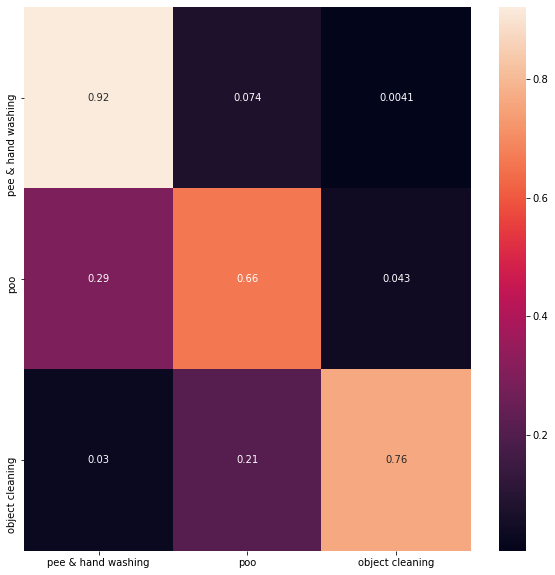

In [24]:
# Confusion matrix
my_confusion = confusion_matrix(ground_truth_str_np, prediction_str_np, labels = label_range)
my_confusion_normalized = my_confusion.copy().astype(np.float)
for i in range(my_confusion_normalized.shape[0]):
    my_confusion_normalized[i] = my_confusion_normalized[i] / np.sum(my_confusion_normalized[i])
df_cm = pd.DataFrame(my_confusion_normalized, index = label_range, columns = label_range)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)

### Silhouette Coefficient

In [25]:
silhouette_score(sub_val_df, val_df[["label"]].to_numpy().flatten(), metric = 'euclidean')

0.35729226189762686